In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
def plot_digit(data: np.array) -> None:
    image = data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")


def encode_label(j: str) -> np.array: 
    e = np.zeros((10, 1))
    e[int(j)] = 1.0
    return e


def prepare_data() -> tuple[np.array, np.array, np.array, np.array, np.array, np.array]:
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X, y = mnist.data, mnist.target
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    y_train = np.array([encode_label(y) for y in y_train])
    y_test = np.array([encode_label(y) for y in y_test])
    
    return X_train, y_train, X_test, y_test, X_val, y_val


def plot_average_digit(X: np.array, y: np.array, digit: int) -> None:
    check_8 = [x for x, y in zip(X, y) if y[digit] == 1.0]
    check_8_array = np.asarray(check_8)
    average_8 = np.average(check_8_array, axis=0)
    plt.figure(figsize=(10, 10))
    plot_digit(average_8)


14000


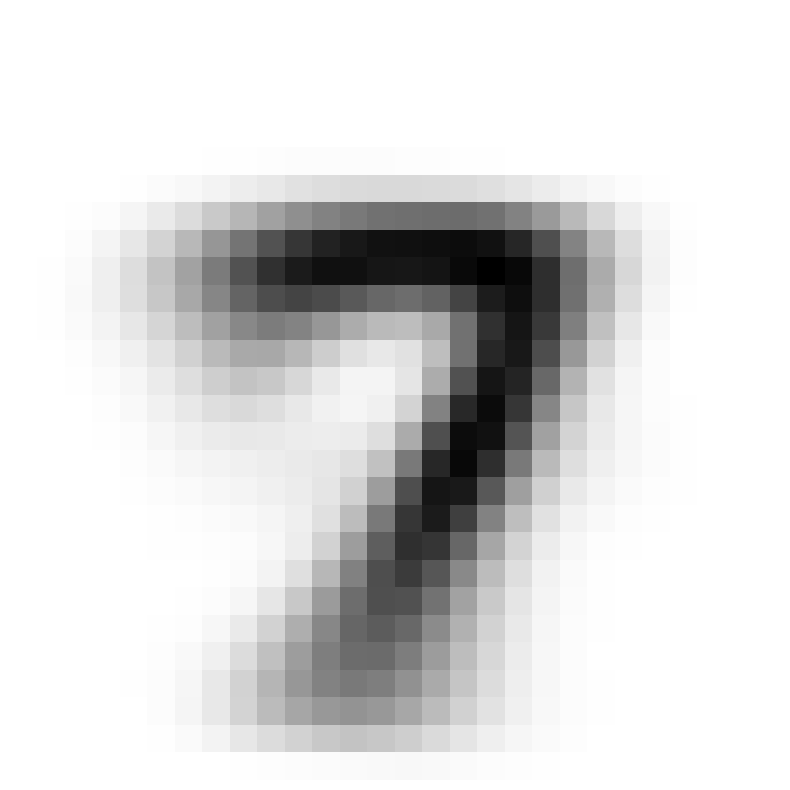

In [3]:
X_train, y_train, X_test, y_test, X_val, y_val = prepare_data()
plot_average_digit(X_train, y_train, 7)
print(len(X_test))

In [4]:
import seaborn as sns
from matplotlib.patches import Rectangle

def plot_digit_centroid_similarity(X: np.ndarray, y: np.ndarray) -> plt.Axes:
    """
    Draw a 10×10 heat-map of cosine similarities between
    digit centroids and return the Axes.
    """
    # Handle both one-hot encoded and raw labels
    if y.ndim > 1 and y.shape[1] == 10:  # One-hot encoded
        labels = np.argmax(y, axis=1)
    else:  # Raw labels (strings or ints)
        labels = np.array([int(label) for label in y])
    
    # Compute centroids for each digit 0-9
    centroids = np.zeros((10, X.shape[1]))
    for digit in range(10):
        digit_mask = labels == digit
        centroids[digit] = np.mean(X[digit_mask.squeeze()], axis=0)
    
    # L2-normalize each centroid
    norms = np.linalg.norm(centroids, axis=1, keepdims=True)
    centroids_normalized = centroids / norms
    
    # Compute 10×10 cosine similarity matrix
    similarity_matrix = np.dot(centroids_normalized, centroids_normalized.T)
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)],
                cbar_kws={'label': 'cosine similarity'}, ax=ax)
    ax.set_xlabel('Digit')
    ax.set_ylabel('Digit')
    ax.set_title('Cosine Similarity Between Digit Centroids')
    
    # Bonus: Add inset showing digit 8
    # inset_ax = fig.add_axes([0.02, 0.02, 0.15, 0.15])  # [left, bottom, width, height]
    # digit_8_samples = X[labels == 8]
    # avg_digit_8 = np.mean(digit_8_samples, axis=0).reshape(28, 28)
    # inset_ax.imshow(avg_digit_8, cmap='binary')
    # inset_ax.set_title('Avg digit 8', fontsize=8)
    # inset_ax.axis('off')
    
    return centroids, centroids_normalized, ax


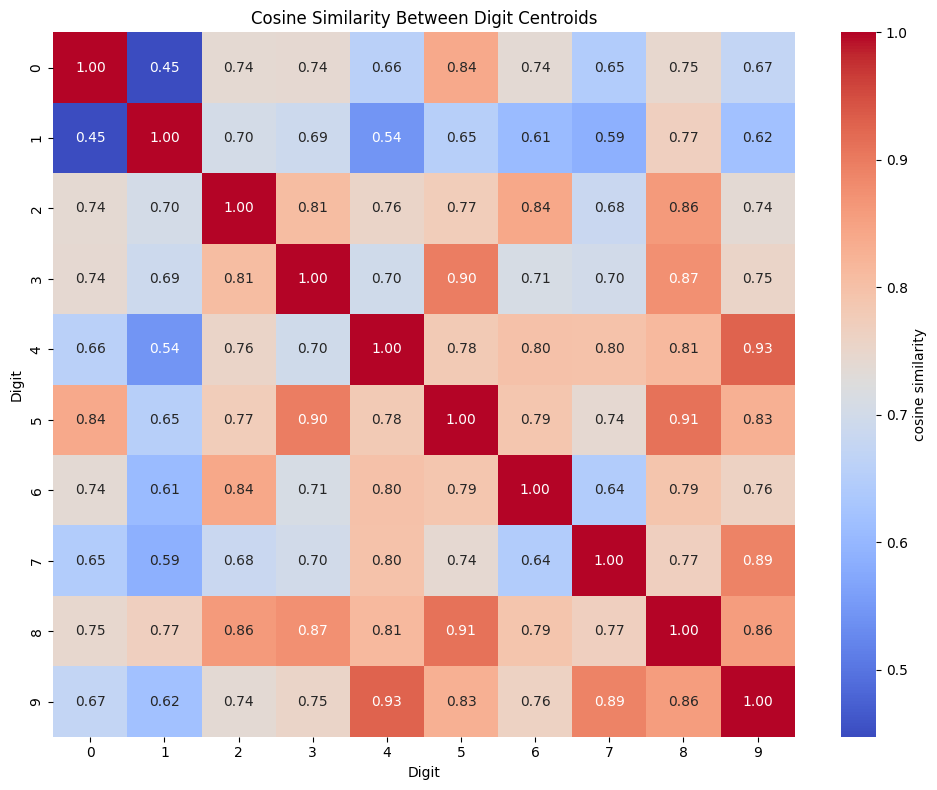

In [5]:
# Test the function with validation data (raw labels)
centroids, centroids_normalized, ax = plot_digit_centroid_similarity(X_train, y_train)
plt.tight_layout()
plt.show()


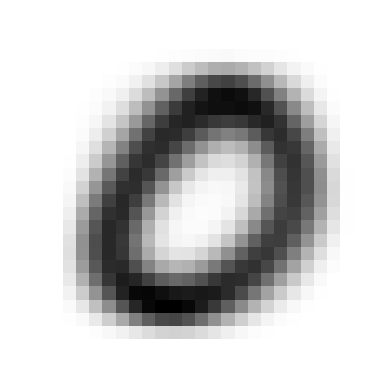

In [6]:
plot_digit(centroids_normalized[0].reshape(28, 28))


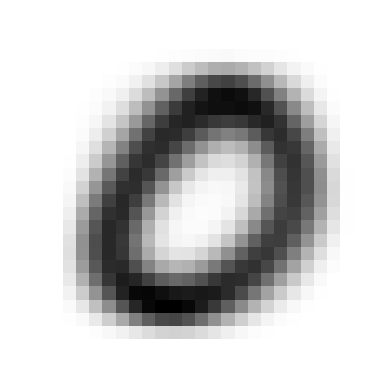

In [7]:
plot_digit(centroids[0].reshape(28, 28))


### Trying predictions using cosine similarity ###

In [8]:
import numpy as np

def compute_digit_centroids(X: np.ndarray, y: np.ndarray, normalized: bool = True) -> np.ndarray:
    """
    Return a (10, D) array of L2-normalised centroids,
    i.e. mean vector per digit divided by its norm.
    """
    if y.ndim > 1 and y.shape[1] == 10:  # One-hot encoded
        labels = np.argmax(y, axis=1)
    else:  # Raw labels (strings or ints)
        labels = np.array([int(label) for label in y])
    
    # Compute centroids for each digit 0-9
    centroids = np.zeros((10, X.shape[1]))
    for digit in range(10):
        digit_mask = labels == digit
        centroids[digit] = np.mean(X[digit_mask.squeeze()], axis=0)
    
    if normalized:
        # L2-normalize each centroid
        norms = np.linalg.norm(centroids, axis=1, keepdims=True)
        centroids_normalized = centroids / norms
    else:
        centroids_normalized = centroids
        
    return centroids_normalized

def predict_digits_cosine(X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Vectorised. For each row of X, compute cosine similarity
    to all ten centroids and return the arg-max label array
    (dtype=int, shape (n_samples,)).
    """
    X_norms = np.linalg.norm(X, axis=1, keepdims=True)
    X_normalized = np.where(X_norms == 0, 0, X / X_norms)
    similarities = np.dot(X_normalized, centroids.T)
    similarities[X_norms.flatten() == 0] = -1e9
    return np.argmax(similarities, axis=1).astype(int)

def evaluate_digit_classifier(X: np.ndarray, y: np.ndarray, centroids: np.ndarray) -> float:
    """
    Predict using the centroids and return accuracy ∈ [0,1].
    """
    true_labels = np.argmax(y, axis=1) if y.ndim > 1 and y.shape[1] == 10 else np.array([int(i) for i in y])
    return np.mean(predict_digits_cosine(X, centroids) == true_labels)


In [9]:
# Test the cosine similarity classifier
cents = compute_digit_centroids(X_train, y_train)
train_acc = evaluate_digit_classifier(X_train, y_train, cents)
test_acc = evaluate_digit_classifier(X_test, y_test, cents)

print(f"Training accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


Training accuracy: 0.1006
Test accuracy: 0.1008


### Solution in the book ###

In [10]:
cents = compute_digit_centroids(X_train, y_train, normalized=True)

X_train_normalized = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
x_3 = X_train_normalized[2]
x_14 = X_train_normalized[13]

W = cents[8].T

print(np.dot(x_3, W))
print(np.dot(x_14, W))

x_3 = X_train_normalized[2]
x_14 = X_train_normalized[13]

W = cents[8].T

print(np.dot(x_3, W))
print(np.dot(x_14, W))

0.5219230700729452
0.6024580051579104
0.5219230700729452
0.6024580051579104


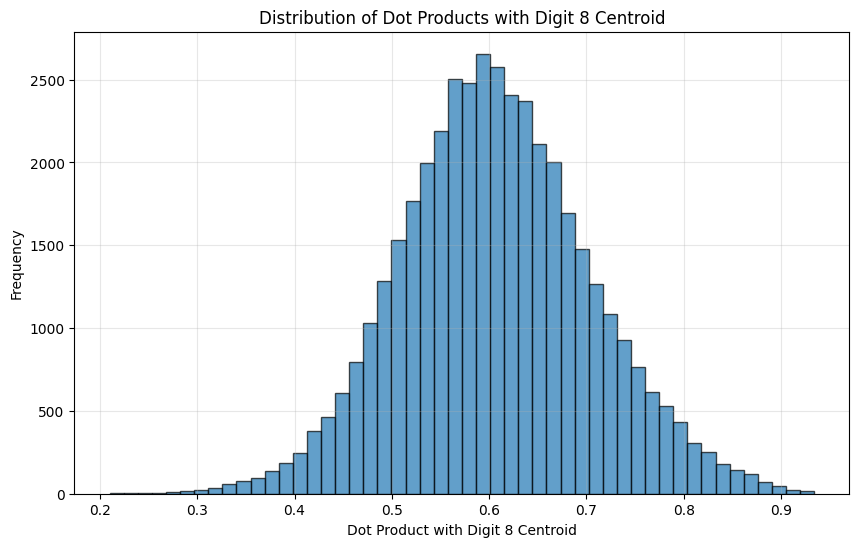

Mean: 0.6065
Std: 0.0980
Min: 0.2100
Max: 0.9340


In [11]:
import matplotlib.pyplot as plt

# Compute the dot products
dot_products = np.dot(X_train_normalized, cents[8].T)

# Create distribution plot
plt.figure(figsize=(10, 6))
plt.hist(dot_products, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Dot Product with Digit 8 Centroid')
plt.ylabel('Frequency')
plt.title('Distribution of Dot Products with Digit 8 Centroid')
plt.grid(True, alpha=0.3)
plt.show()

# Also show some basic statistics
print(f"Mean: {np.mean(dot_products):.4f}")
print(f"Std: {np.std(dot_products):.4f}")
print(f"Min: {np.min(dot_products):.4f}")
print(f"Max: {np.max(dot_products):.4f}")

In [12]:
def sigmoid_double(x): 
    return 1.0 / (1.0 + np.exp(-x))


def sigmoid(z): 
    return np.vectorize(sigmoid_double)(z)
    

def predict(x, W, bias, k):
    return sigmoid(k*(np.dot(x, W) + bias))


def evaluate_digit_classifier(X, y, digit, threshold, bias, k, cents):
    correct_positive = 0
    correct_negative = 0
    for data_point, data_y in zip(X, y):
        if predict(data_point, cents[digit].T, bias, k) > threshold and np.argmax(data_y) == digit:
            correct_positive += 1
        if predict(data_point, cents[digit].T, bias, k) < threshold and np.argmax(data_y) != digit:
            correct_negative += 1
        
    return correct_positive/len(X), correct_negative/len(X)

In [13]:
bias = -1 * np.mean(np.dot(X_train_normalized, cents[8].T))
k = 1.81/np.std(np.dot(X_train_normalized, cents[8].T)) 
print(predict(x_3, cents[8].T, bias, 1))
print(predict(x_14, cents[8].T, bias, 1))

0.47886697364844966
0.49898811114748937


In [14]:
len(centroids)

10

In [15]:
len(centroids)

10

In [16]:
len(centroids)

10

In [17]:
len(centroids)

10

In [18]:
len(centroids)

10

In [19]:
len(centroids)

10

In [20]:
len(centroids)

10

In [21]:
np.argmax(y_train, axis=1) == 8

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [22]:
cents = compute_digit_centroids(X_train, y_train, normalized=True)

X_train_8 = X_train_normalized[(np.argmax(y_train, axis=1) == 8).squeeze()]
y_train_8 = y_train[(np.argmax(y_train, axis=1) == 8).squeeze()]
evaluate_digit_classifier(X_train_8, y_train_8, 8, 0.6, bias, k, cents)

(0.9057692307692308, 0.0)

In [23]:
evaluate_digit_classifier(X_train_normalized, y_train, 8, 0.6, bias, k, cents)

(0.08971428571428572, 0.5936666666666667)

In [24]:
X_test_normalized = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)
evaluate_digit_classifier(X_test_normalized, y_test, 8, 0.5, bias, 1, cents)

(0.08714285714285715, 0.5172857142857142)

In [ ]:
# ---------- Multi-Class Helper Functions ----------

def softmax(z: np.ndarray) -> np.ndarray:
    """Row-wise stable softmax."""
    z_max = z.max(axis=1, keepdims=True)
    e = np.exp(z - z_max)
    return e / e.sum(axis=1, keepdims=True)

def compute_multiclass_centroids(X: np.ndarray, y_onehot: np.ndarray) -> np.ndarray:
    """
    Return (10, D) matrix where row i is the mean of all rows of X whose one-hot label is digit i.
    Assumes X is already standardised / normalised.
    """
    digits = y_onehot.argmax(axis=1)
    centroids = np.stack([X[digits == d].mean(axis=0) for d in range(10)], axis=0)
    return centroids

def calibrate_bias_k(
    X: np.ndarray, centroids: np.ndarray, slope_const: float = 1.81
) -> tuple[np.ndarray, np.ndarray]:
    """
    For each digit i compute:
        bias[i] = −mean(X · centroid_i^T)
        k[i]    = slope_const / std(X · centroid_i^T)
    Returns bias, k of shape (10,).
    """
    dots = X @ centroids.T        # (N, 10)
    bias  = -dots.mean(axis=0)     # (10,)
    k     = slope_const / dots.std(axis=0)
    return bias, k


In [ ]:
# ---------- Multi-Class Core Model ----------

def predict_proba(
    X: np.ndarray, centroids: np.ndarray, bias: np.ndarray, k: np.ndarray
) -> np.ndarray:
    """
    Return (N, 10) matrix of softmax probabilities.
    Each logit_j = k[j] * (X · centroid_j^T + bias[j]).
    """
    logits = (X @ centroids.T + bias) * k          # broadcasting (N,10)
    return softmax(logits)

def classify(
    X: np.ndarray, centroids: np.ndarray, bias: np.ndarray, k: np.ndarray
) -> np.ndarray:
    """Return predicted digit labels (N,)."""
    return predict_proba(X, centroids, bias, k).argmax(axis=1)


In [ ]:
# ---------- Multi-Class Evaluation ----------

def precision_recall_by_digit(
    y_true: np.ndarray, y_pred: np.ndarray, num_classes: int = 10
) -> dict[int, tuple[float, float]]:
    """
    Returns {digit: (precision, recall)}.
    Inputs are 1-D integer label arrays.
    """
    metrics = {}
    for d in range(num_classes):
        tp = np.sum((y_pred == d) & (y_true == d))
        fp = np.sum((y_pred == d) & (y_true != d))
        fn = np.sum((y_pred != d) & (y_true == d))
        precision = tp / (tp + fp) if (tp + fp) else 0.0
        recall    = tp / (tp + fn) if (tp + fn) else 0.0
        metrics[d] = (precision, recall)
    return metrics

def evaluate_multiclass(
    X: np.ndarray,
    y_onehot: np.ndarray,
    centroids: np.ndarray,
    bias: np.ndarray,
    k: np.ndarray,
) -> tuple[float, dict[int, tuple[float, float]]]:
    """
    Returns overall accuracy and per-digit precision/recall.
    """
    y_true = y_onehot.argmax(axis=1)
    y_pred = classify(X, centroids, bias, k)
    accuracy = (y_true == y_pred).mean()
    pr_dict  = precision_recall_by_digit(y_true, y_pred)
    return accuracy, pr_dict


In [ ]:
# ---------- Training and Testing the Multi-Class Classifier ----------

# Normalize training set by mean/std then apply to test set
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0) + 1e-8
X_train_n = (X_train - mu) / sigma
X_test_n  = (X_test  - mu) / sigma

# Compute centroids and calibration parameters
centroids = compute_multiclass_centroids(X_train_n, y_train)
bias, k   = calibrate_bias_k(X_train_n, centroids)

print("Multi-class classifier trained!")
print(f"Centroids shape: {centroids.shape}")
print(f"Bias shape: {bias.shape}")
print(f"K shape: {k.shape}")


In [ ]:
# Evaluate the multi-class classifier
acc_train, pr_train = evaluate_multiclass(X_train_n, y_train, centroids, bias, k)
acc_test, pr_test = evaluate_multiclass(X_test_n, y_test, centroids, bias, k)

print(f"Training accuracy: {acc_train:.4f}")
print(f"Test accuracy: {acc_test:.4f}")
print("\nPer-digit performance on test set:")
for d, (prec, rec) in pr_test.items():
    print(f"Digit {d}:  precision {prec:.3f}   recall {rec:.3f}")


In [ ]:
# ---------- Demonstration: Multi-Class Predictions ----------

# Get probability predictions for some test samples
sample_indices = [0, 1, 2, 3, 4]
sample_X = X_test_n[sample_indices]
sample_y_true = y_test[sample_indices].argmax(axis=1)

# Get probability predictions
probabilities = predict_proba(sample_X, centroids, bias, k)
predicted_labels = classify(sample_X, centroids, bias, k)

print("Sample predictions:")
print("Index | True | Pred | Confidence | Top 3 probabilities")
print("-" * 60)

for i, (true_label, pred_label, probs) in enumerate(zip(sample_y_true, predicted_labels, probabilities)):
    confidence = probs[pred_label]
    # Get top 3 predictions
    top3_indices = np.argsort(probs)[-3:][::-1]
    top3_str = ", ".join([f"{idx}:{probs[idx]:.3f}" for idx in top3_indices])
    
    print(f"{sample_indices[i]:5d} | {true_label:4d} | {pred_label:4d} | {confidence:10.3f} | {top3_str}")

# Visualize a few examples
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, idx in enumerate(sample_indices):
    # Reconstruct original image (denormalize)
    original_img = (X_test_n[idx] * sigma + mu).reshape(28, 28)
    axes[i].imshow(original_img, cmap='binary')
    axes[i].set_title(f'True: {sample_y_true[i]}, Pred: {predicted_labels[i]}')
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()
